# Player Behaviour EDA and AB Tests

Kaggle challange to analyze mobile game dataset and perform AB Tests

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

 - userid - User ID
 - version - version of game: categorical value: gate_30, gate_40 values available for testing
 - sum_gamerounds - number of game rounds played by user
 - retention_1 - 1st day retention 
 - retention_7 - 7th day retention 
 

## Imports

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [239]:
df = pd.read_csv('/Users/alex/Documents/mobile game/cookie_cats.csv')
df.shape

(90189, 5)

## EDA

In [240]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [241]:
# check nans
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [242]:
# get number of unique values in each col
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [243]:
# numger of players in each group
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [244]:
# encode categorical features
from sklearn.preprocessing import LabelEncoder

# encode categorical features
le = LabelEncoder()

for col in ['version', 'retention_1', 'retention_7']:
    df[col] = le.fit_transform(df[col])

### Numger of Players in Each Group

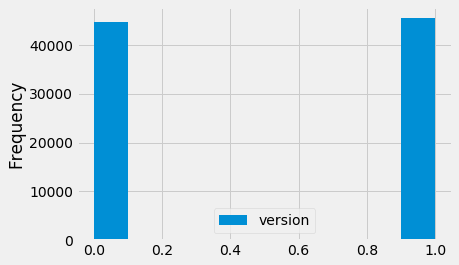

In [245]:
### players group distribution 
df[['version']].plot.hist()

### Players with zero rounds

In [246]:
# number of players with zero rounds
df[df['sum_gamerounds']==0].shape

(3994, 5)

In [247]:
# retention day 1 of players with 0 rounds
df[df['sum_gamerounds']==0].retention_1.value_counts()

0    3907
1      87
Name: retention_1, dtype: int64

In [248]:
# retention day 1 of players with 0 rounds
df[df['sum_gamerounds']==0].retention_7.value_counts()

0    3965
1      29
Name: retention_7, dtype: int64

4.4% of players have zero gamerounds. Looks like they have some onboarding issues. We need to get into it more closer with additional analysis of behavioral data.

In [249]:
# filter out players with zero rounds. 
df=df[df['sum_gamerounds']!=0]

### Cumulative Distribution 

In [250]:
# cumulative distribution function
def ecdf(data):
    """ECDF for a 1D array"""
    
    n = len(data)
    x = np.sort(data)    
    y = np.arange(1, n+1) / n

    return x, y

In [251]:
# drop extreme outlier
df.drop(index=57702, inplace=True)

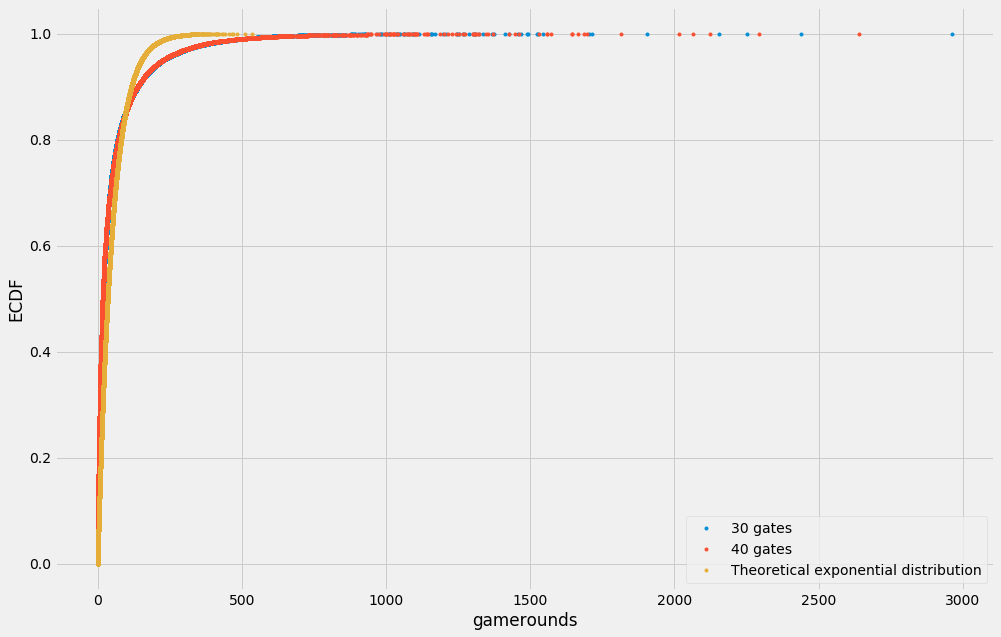

In [252]:
# cumulative distribution of gaming rounds 
np.random.seed(42)
plt.figure(figsize=(15, 10))
x_30, y_30 = ecdf(df[df.version == 0].sum_gamerounds)
x_40, y_40 = ecdf(df[df.version == 1].sum_gamerounds)

x_theor, y_theor = ecdf(np.random.exponential(scale=51, size=50000))

plt.plot(x_30, y_30, marker='.', linestyle='none')
plt.plot(x_40, y_40, marker='.', linestyle='none')

plt.plot(x_theor, y_theor, marker='.', linestyle='none')

plt.legend(('30 gates', '40 gates', 'Theoretical exponential distribution'), loc='lower right')
plt.xlabel('gamerounds')
plt.ylabel('ECDF')

plt.show()


As a result we have something close to expnential probability distribution. 30 and 40 gates look like have the same distribution.  

### Kernel Density Estimation

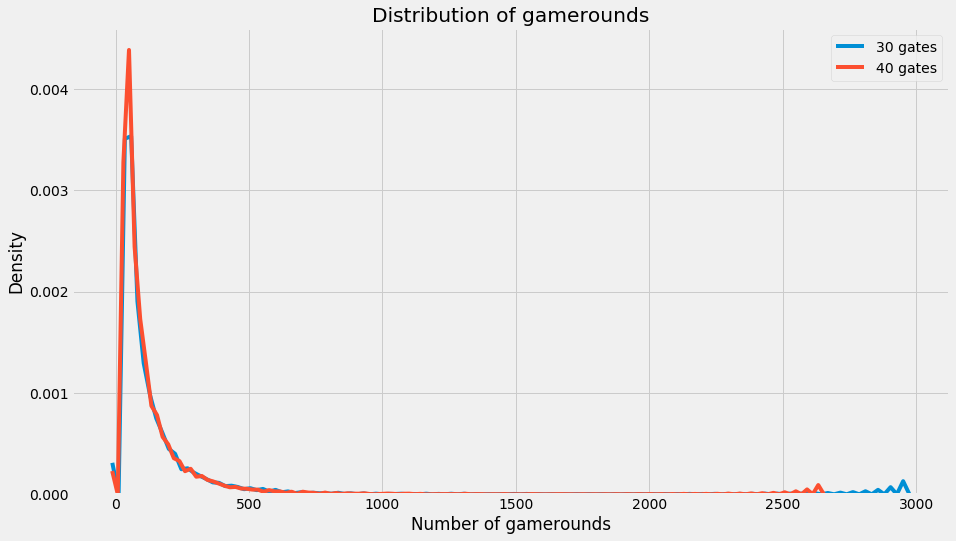

In [253]:
# KDE for gamerounds
plt.figure(figsize = (14, 8))

# KDE plot of gamerounds that were on gate_30 version
sns.kdeplot(df.loc[df['version'] == 0, 'sum_gamerounds'], label = '30 gates')

# KDE plot of gamerounds that were on gate_40 version
sns.kdeplot(df.loc[df['version'] == 1, 'sum_gamerounds'], label = '40 gates')

# labels
plt.xlabel('Number of gamerounds'); plt.ylabel('Density'); plt.title('Distribution of gamerounds');

## Feature Engeneering

In [254]:
# create new retention category feature
df['retention_feat'] = df['retention_1'].astype(str)+df['retention_7'].astype(str)
# values counts of new feature
df['retention_feat'].value_counts()

00    42554
10    26889
11    13177
01     3574
Name: retention_feat, dtype: int64

In [255]:
# encoding with numerical values
# 0 - no retention
# 1 - first day retention only
# 2 - 7th day retention only
# 3 - retention 1 and 7 day
df.retention_feat.replace({'00': 0, '10': 1, '01': 2, '11': 3}, inplace=True)

In [256]:
# value counts of retention options for gate_30
df[df['version']==0].retention_feat.value_counts()/len(df[df['version']==0])*100

0    49.013143
1    31.144474
3    15.609653
2     4.232730
Name: retention_feat, dtype: float64

In [257]:
# value counts of retention options for gate_40
df[df['version']==1].retention_feat.value_counts()/len(df[df['version']==1])*100

0    49.721404
1    31.246546
3    14.970529
2     4.061521
Name: retention_feat, dtype: float64

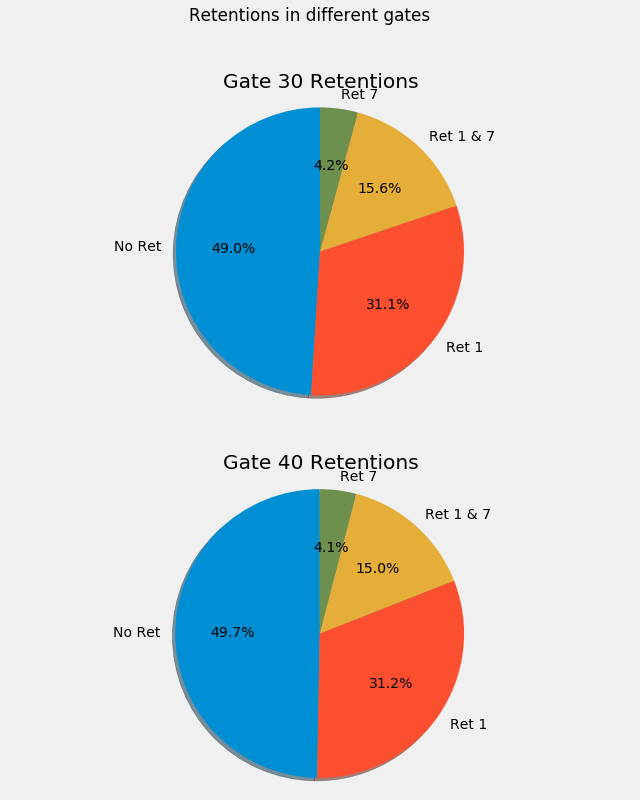

In [258]:
# create piechart to explore retentions

fig, axs = plt.subplots(2, figsize=[10, 12])
fig.suptitle('Retentions in different gates')
axs[0].pie(df[df['version']==0].retention_feat.value_counts()/len(df[df['version']==0])*100,  labels=['No Ret', 'Ret 1', 'Ret 1 & 7', 'Ret 7'], autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title('Gate 30 Retentions')



axs[1].pie(df[df['version']==1].retention_feat.value_counts()/len(df[df['version']==1])*100,  labels=['No Ret', 'Ret 1', 'Ret 1 & 7', 'Ret 7'], autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title('Gate 40 Retentions')

plt.show()

In [259]:
# create data frames for gate_30 and gate_40 versions
df_30 = df[df['version']==0].reset_index().drop('index', axis=1)
df_40 = df[df['version']==1].reset_index().drop('index', axis=1)

## Hypothesis testing of retention 1

Null Hypothesis: gate_30 and gate_40 have  identical probability distributons of retention_1

In [260]:
# persent of retention 1
print(df_30['retention_1'].sum()/len(df_30)*100)
print(df_40['retention_1'].sum()/len(df_40)*100)

46.75412749637529
46.217074967765704


In [261]:
# create function to draw replicates
def draw_reps(data, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = np.mean(np.random.choice(data, size=len(data)))

    return bs_replicates

In [262]:
# create replicates for gate_30 and gate_40
reps_30_ret1 = draw_reps(df_30['retention_1'], 10000)
reps_40_ret1 = draw_reps(df_40['retention_1'], 10000)

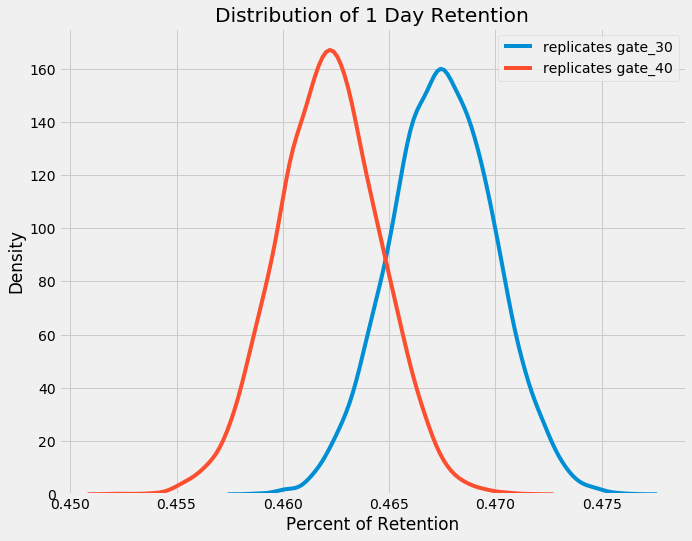

In [263]:
# create kernel density estimation for replicates
plt.figure(figsize = (10, 8))

sns.kdeplot(reps_30_ret1, label = 'replicates gate_30')
sns.kdeplot(reps_40_ret1, label = 'replicates gate_40')

# labels
plt.xlabel('Percent of Retention'); plt.ylabel('Density'); plt.title('Distribution of 1 Day Retention');

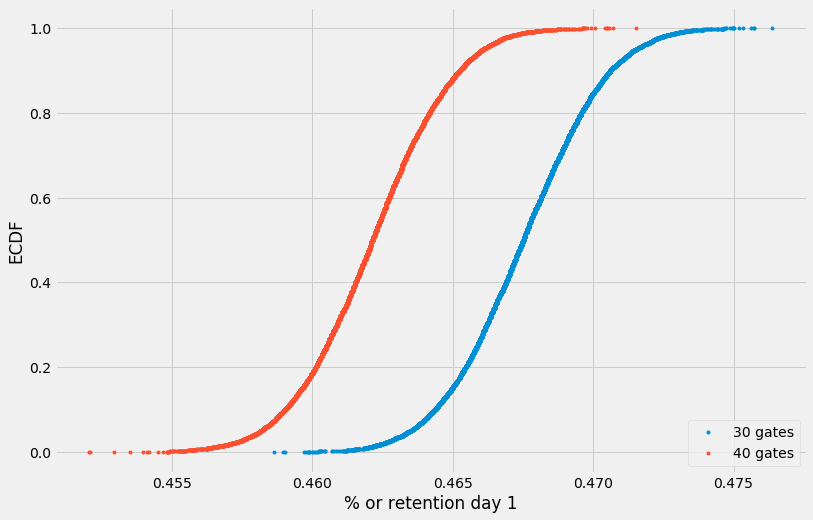

In [268]:
# cumulative distribution of gaming rounds 
np.random.seed(42)
plt.figure(figsize=(12, 8))
x_30, y_30 = ecdf(reps_30_ret1)
x_40, y_40 = ecdf(reps_40_ret1)

plt.plot(x_30, y_30, marker='.', linestyle='none')
plt.plot(x_40, y_40, marker='.', linestyle='none')

plt.legend(('30 gates', '40 gates'), loc='lower right')
plt.xlabel('% or retention day 1')
plt.ylabel('ECDF')

plt.show()

In [271]:
# create difference array between gate_30 and gate_40 replicates
diff_ret1 = reps_30_ret1 - reps_40_ret1

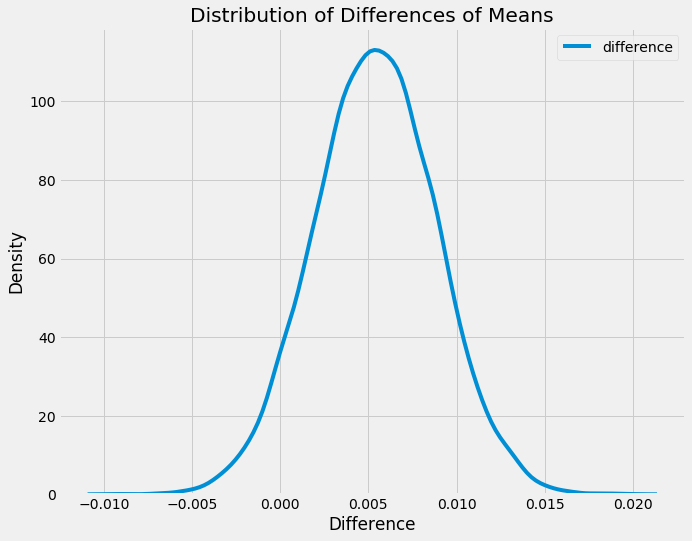

In [305]:
# plot difference in means 
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(diff_ret1, label = 'difference')

# Labeling of plot
plt.xlabel('Difference'); plt.ylabel('Density'); plt.title('Distribution of Differences of Means');

In [273]:
# Calculate probability
print('Probability that gate_30 retention is greater than gate_40 is: ', (diff_ret1>0).sum()/len(diff))

Probability that gate_30 retention is greater than gate_40 is:  0.9406


## Hypothesis testing of retention 7

In [275]:
# persent of retention 7
print(df_30['retention_7'].sum()/len(df_30)*100)
print(df_40['retention_7'].sum()/len(df_40)*100)

19.842383424535804
19.03205010130779


In [276]:
# create replicates for gate_30 and gate_40 (retention 7)
reps_30_ret7 = draw_reps(df_30['retention_7'], 10000)
reps_40_ret7 = draw_reps(df_40['retention_7'], 10000)

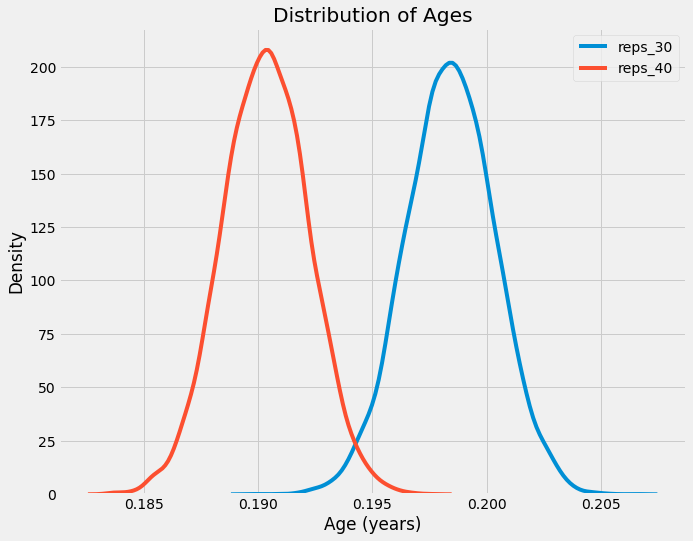

In [277]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(reps_30_ret7, label = 'reps_30')

# KDE plot of loans which were not repaid on time
sns.kdeplot(reps_40_ret7, label = 'reps_40')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

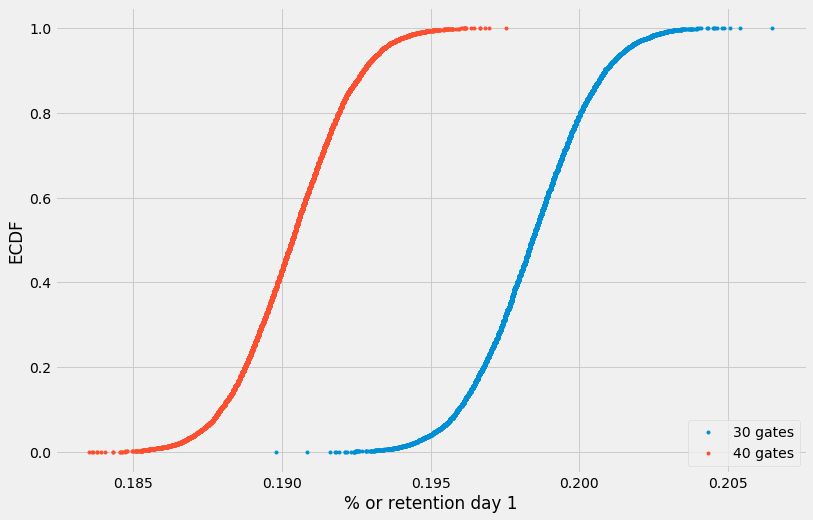

In [278]:
# cumulative distribution of gaming rounds 
np.random.seed(42)
plt.figure(figsize=(12, 8))
x_30, y_30 = ecdf(reps_30_ret7)
x_40, y_40 = ecdf(reps_40_ret7)

#x_theor, y_theor = ecdf(np.random.exponential(scale=51, size=50000))

plt.plot(x_30, y_30, marker='.', linestyle='none')
plt.plot(x_40, y_40, marker='.', linestyle='none')

#plt.plot(x_theor, y_theor, marker='.', linestyle='none')

plt.legend(('30 gates', '40 gates'), loc='lower right')
plt.xlabel('% or retention day 1')
plt.ylabel('ECDF')

plt.show()




In [281]:
# create difference array between gate_30 and gate_40 replicates
diff_ret7 = reps_30_ret7 - reps_40_ret7

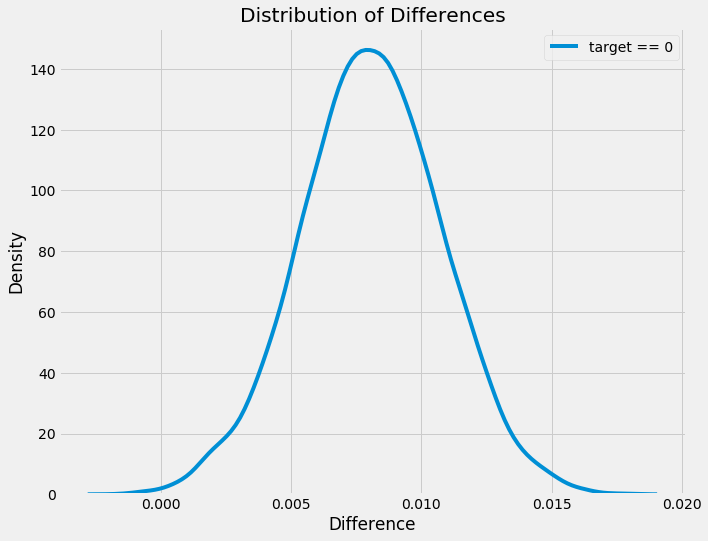

In [304]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(diff_ret7, label = 'target == 0')

# KDE plot of loans which were not repaid on time
#sns.kdeplot(reps_40, label = 'target == 1')

# Labeling of plot
plt.xlabel('Difference'); plt.ylabel('Density'); plt.title('Distribution of Differences');

In [283]:
(diff_ret7>0).sum()/len(diff)

0.9988

## Hypothesis Testing of Retention 1

Increase in 1 day retention when we move to level 40 (-0.187%)

In [284]:
# observed data mean differences test statistics 
ret1_mean = df_30['retention_1'].sum()/len(df_30) - df_40['retention_1'].sum()/len(df_40)
ret1_mean

0.005370525286095829

In [285]:
# function to create permutataion samples from data
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [286]:
# create permutation samples
sample_1, sample_2 = permutation_sample(df_30['retention_1'], df_40['retention_1'])

In [288]:
# function to create permutation replicates
def draw_perm_reps(data_1, data_2, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

In [289]:
# create permutation replicates
perm_repl_ret1 = draw_perm_reps(df_30['retention_1'], df_40['retention_1'], size=10000)

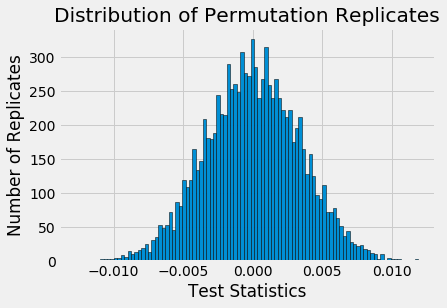

In [303]:
# distribution of permutation replicates
plt.style.use('fivethirtyeight')
plt.hist(perm_repl_ret1, bins = 100, edgecolor = 'k');
plt.xlabel('Test Statistics'); plt.ylabel('Number of Replicates'); 
plt.title('Distribution of Permutation Replicates');

In [291]:
# p-value calculation 
p_value_ret1 = np.sum(perm_repl_ret1>=ret1_mean)/10000
print('p-value for retention 1 day: ', p_value_ret1)

p-value for retention 1 day:  0.0589


## Hypothesis Testing of Retention 7

In [292]:
print(df_30['retention_7'].sum()/len(df_30)*100)
print(df_40['retention_7'].sum()/len(df_40)*100)

19.842383424535804
19.03205010130779


In [293]:
# observed data mean differences test statistics 
ret7_mean = df_30['retention_7'].sum()/len(df_30) - df_40['retention_7'].sum()/len(df_40)
ret7_mean

0.00810333323228013

In [294]:
# create permutation replicates for retention 7
perm_repl_ret7 = draw_perm_reps(df_30['retention_7'], df_40['retention_7'], size=10000)

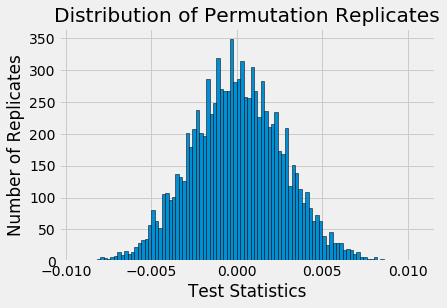

In [301]:
# distribution of permutation replicates
plt.style.use('fivethirtyeight')
plt.hist(perm_repl_ret7, bins = 100, edgecolor = 'k');
plt.xlabel('Test Statistics'); plt.ylabel('Number of Replicates'); 
plt.title('Distribution of Permutation Replicates');

In [296]:
p_value_ret7 = np.sum(perm_repl_ret7>=ret7_mean)/10000
print('p-value for retention 1 day: ', p_value_ret7)

p-value for retention 1 day:  0.0017


## Overall Retention

In [297]:
# observed data mean differences test statistics 
ret_mean_diff = np.mean(df_30['retention_feat']) - np.mean(df_40['retention_feat'])
ret_mean_diff

0.02157719175065609

In [298]:
# create permutation replicates for new retention feature
perm_repl_ret = draw_perm_reps(df_30['retention_feat'], df_40['retention_feat'], size=10000)

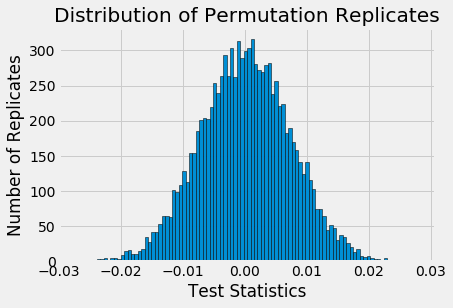

In [302]:
# distribution of permutation replicates
plt.style.use('fivethirtyeight')
plt.hist(perm_repl_ret, bins = 100, edgecolor = 'k');
plt.xlabel('Test Statistics'); plt.ylabel('Number of Replicates'); 
plt.title('Distribution of Permutation Replicates');

In [300]:
p_value_ret7 = np.sum(perm_repl_ret>=ret_mean)/10000
print('p-value for retention feature: ', p_value_ret7)

p-value for retention feature:  0.0014
